In [20]:
import pandas as pd
import numpy as np
import glob
import io
from ipywidgets import Output, IntSlider, DatePicker, interact, IntRangeSlider, Label, link, dlink
from IPython.display import clear_output
import datetime

eliminar_nulos = True
dir_datos = '../O2Measures'

In [21]:
def get_file_contents(file_name):
    """
    Gets the file content removing possibly duplicated content
    @param: string file_name
    @return: string content of the file
    """
    with open(file_name) as f:
        data = f.read()
        if data.count('Time') > 1:
            token = 'Time'
            position = data.find(token, 10)
            return data[0:position]
        else:
            return data

In [22]:
csv = None
num = 0
for file in glob.glob(dir_datos + '/*.csv'):
    content = get_file_contents(file)
    num += 1
    if csv is None:
        csv = pd.read_csv(io.StringIO(content))
    else:
        csv = pd.concat([csv, pd.read_csv(io.StringIO(content))])
print(f"Loaded {num} files.")

Loaded 17 files.


In [23]:
#Elimina los nulos si procede
if eliminar_nulos:
    antes = csv.count()[0]
    csv = csv.replace(255, np.nan).dropna()
    print("Se han eliminado {0} registros".format(antes-csv.count()[0]))

Se han eliminado 74 registros


In [24]:
#Cambia tipo a los campos numéricos
cambio = {'SpO2(%)': 'unsigned', 'Pulse Rate(bmp)': 'unsigned', 'Movimiento': 'unsigned', 'Vibración': 'unsigned'}
for variable, tipo in cambio.items():
    csv[variable] = pd.to_numeric(csv[variable], downcast=tipo)

In [25]:
#Cambia tipo a la fecha
p1='%H:%M:%S %b %d'
p2='%Y'
special_char = (csv['Time'][0:1])[0][15]
formato = p1 + special_char + p2
csv['Time'] = pd.to_datetime(csv['Time'], format=formato)

In [26]:
#Actualiza fechas de 1970 generadas la noche del cambio de hora 29/03/2020
inicio = pd.to_datetime('12/12/1969')
fin = pd.to_datetime('12/12/2018')
registros = csv[csv.Time.between(inicio, fin)].count()[0]
sumando = pd.to_timedelta(365 * 50 + 100, unit='d')
mask = (csv.Time.between(inicio, fin))
csv.loc[mask, 'Time'] = csv[mask]['Time'] + sumando
print(f"Se han corregido {registros} registros")
registros = csv[csv.Time.between(inicio, fin)].count()[0]
print(f"Ahora quedan {registros} desubicados")

Se han corregido 7137 registros
Ahora quedan 0 desubicados


In [27]:
csv.dtypes

Time               datetime64[ns]
SpO2(%)                     uint8
Pulse Rate(bmp)             uint8
Movimiento                  uint8
Vibración                   uint8
dtype: object

In [28]:
csv = csv.set_index('Time')
#genera dias y noches
noches = csv.between_time('00:00', '11:00')
dias = csv.between_time('11:01', '23:59')
print("Se han partido correctamente los datos?: {0}".format(dias.count()[0] + noches.count()[0] == csv.count()[0]))

Se han partido correctamente los datos?: True


In [29]:
print("==================Días====================")
print(dias.describe())
print("=================Noches===================")
print(noches.describe())

==================Días====================
           SpO2(%)  Pulse Rate(bmp)   Movimiento    Vibración
count  6202.000000      6202.000000  6202.000000  6202.000000
mean     94.510319        92.204773     6.516446     0.041277
std       1.621489        19.454767     9.667866     2.298392
min      88.000000        57.000000     0.000000     0.000000
25%      93.000000        74.000000     2.000000     0.000000
50%      95.000000        91.000000     3.000000     0.000000
75%      96.000000       110.000000     7.000000     0.000000
max      98.000000       131.000000   139.000000   128.000000
=================Noches===================
            SpO2(%)  Pulse Rate(bmp)    Movimiento  Vibración
count  61987.000000     61987.000000  61987.000000    61987.0
mean      97.330747        56.803669      0.586413        0.0
std        0.687652         4.164620      3.758877        0.0
min       92.000000        33.000000      0.000000        0.0
25%       97.000000        54.000000      0.00

In [30]:
def f(control):
    if control is not None:
        fecha = datetime.datetime(control.year, control.month, control.day).strftime("%Y-%m-%d")
        if noches[fecha].size > 0:
            noches[fecha][['SpO2(%)', 'Pulse Rate(bmp)']].plot(figsize=(20,15), color=('orange', 'green'), title='Noche', grid=True)
            dias[fecha][['SpO2(%)', 'Pulse Rate(bmp)']].plot(figsize=(20,15), color=('red', 'blue'), title='Día', grid=True)
        else:
            print("No hay datos")
interact(f, control=DatePicker(description='Fecha'))

interactive(children=(DatePicker(value=None, description='Fecha'), Output()), _dom_classes=('widget-interact',…

<function __main__.f(control)>

Valor mínimo de SpO2 de noche: 92


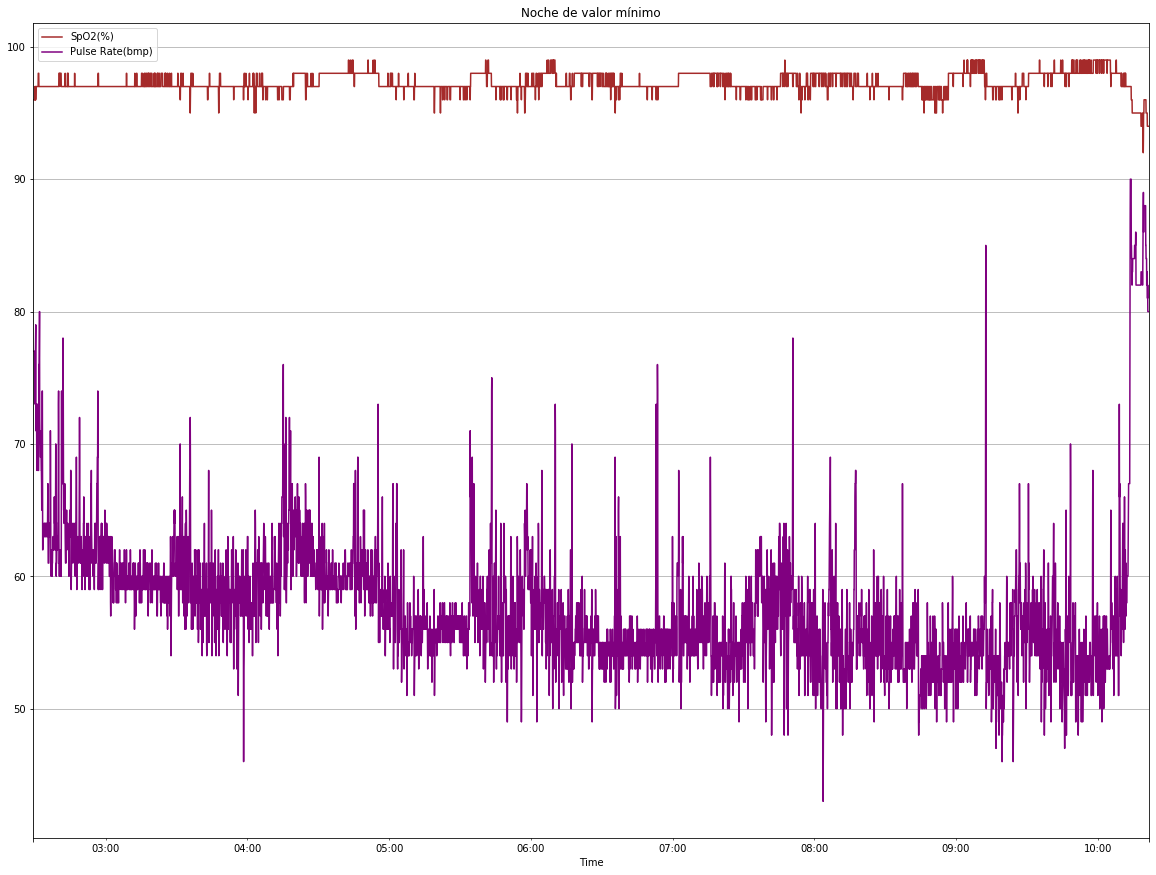

In [31]:
#Imprime el gráfico correspondiente a la noche con el valor mínimo de SpO2(%)
mino2 = noches['SpO2(%)'].min()
mino2_idx = noches['SpO2(%)'].idxmin()
fecha = datetime.date(mino2_idx.year, mino2_idx.month, mino2_idx.day).strftime("%Y-%m-%d")
print(f"Valor mínimo de SpO2 de noche: {mino2}")
noches[fecha][['SpO2(%)', 'Pulse Rate(bmp)']].plot(figsize=(20,15), color=('brown', 'purple'), title='Noche de valor mínimo', grid=True)

In [32]:
def crea_date(indice):
    return datetime.date(indice.year, indice.month, indice.day)
def crea_datetime(indice, hora):
    return datetime.datetime(indice.year, indice.month, indice.day, hora)
def calcula_horas(df, fecha):
    indices = df[fecha.strftime("%Y-%m-%d")].index
    if indices.size == 0:
        return 0, 0
    inicial = indices[0]
    fecha_inicial = crea_date(inicial)
    ultima = noches[fecha_inicial.strftime("%Y-%m-%d")].index[-1] or 0
    hora_inicial = inicial.hour
    hora_final = ultima.hour
    primera = noches.index.min()
    return hora_inicial, hora_final
def crea_grafico(df, fecha, horas):
    ini, fin = horas
    if fecha is not None:
        st = crea_datetime(fecha, ini)
        en = crea_datetime(fecha, fin)
        noches[(df.index >= st) & (df.index <= en)]['SpO2(%)'].plot(legend=False, figsize=(15,10))
def actua(fecha, horas):
    if fecha is not None:
        # Actualiza extremos del intervalo de horas
        min, max = calcula_horas(noches, fecha)
        choras.min = -1 # por si acaso no hay datos evita un error
        choras.max = max
        choras.min = min
        # Calcula intervalo y representa gráfico si hay datos
        st = crea_datetime(fecha, horas[0])
        en = crea_datetime(fecha, horas[1])
        if noches[(noches.index >= st) & (noches.index <= en)]['SpO2(%)'].size > 0:
            noches[(noches.index >= st) & (noches.index <= en)]['SpO2(%)'].plot(legend=False, figsize=(15,10))
        else:
            clear_output()
            print("No hay datos para esa fecha.")
primera = crea_date(noches.index.min())
hora_inicial, hora_final = calcula_horas(noches, primera)
cfecha = DatePicker(description='Fecha', value=primera)
choras = IntRangeSlider(value=[hora_inicial, hora_final], min=hora_inicial, max=hora_final, description='Horas:', continuous_update=True)
interact(actua, fecha=cfecha, horas=choras)

interactive(children=(DatePicker(value=datetime.date(2020, 3, 27), description='Fecha'), IntRangeSlider(value=…

<function __main__.actua(fecha, horas)>

DatePicker(value=datetime.date(2020, 3, 27), description='kk')

IntRangeSlider(value=(2, 10), description='Horas:', max=10, min=2)

Output()

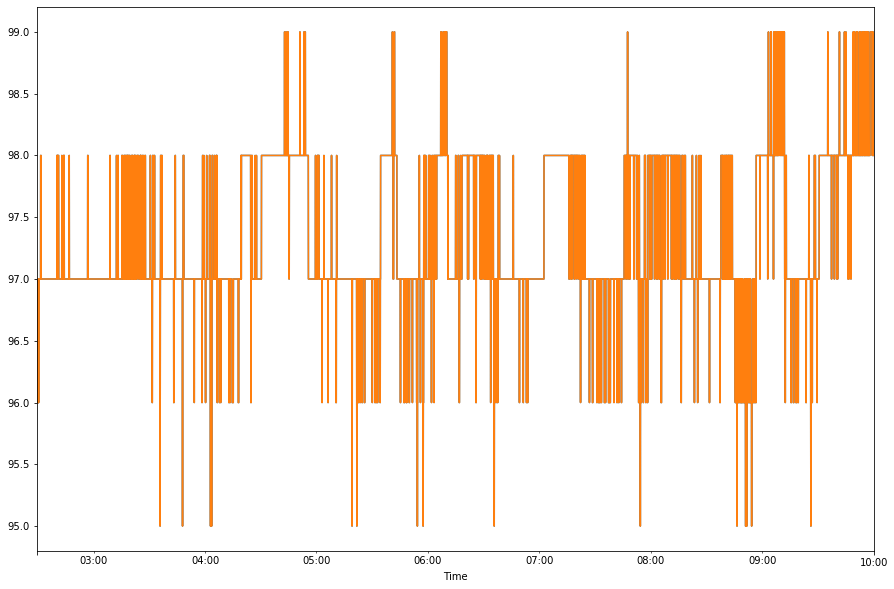

In [33]:

def crea_datetime(indice, hora):
    return datetime.datetime(indice.year, indice.month, indice.day, hora)

def crea_grafico(df, fecha, horas):
    ini, fin = horas
    if fecha is not None:
        st = crea_datetime(fecha, ini)
        en = crea_datetime(fecha, fin)
        return noches[(df.index >= st) & (df.index <= en)]['SpO2(%)'].plot(legend=False, figsize=(15,10))
    else:
        return None
def crea_controlador_horas(hora_inicial, hora_final):
    return IntRangeSlider(value=[hora_inicial, hora_final], min=hora_inicial, max=hora_final, description='Horas:')

def proceso_fecha_test(datos):
    with output:
        print("Éxito",datos)
        fecha = datos.owner.value
        crea_grafico(noches, fecha, horas.value)
def proceso_horas(datos):
    with output:
        print('Cambio Hora')
        fecha = cfecha.value
        grafico = crea_grafico(noches, fecha, datos.new)

indice_primera = noches.index.min()
primera = crea_date(indice_primera)
ini, fin = calcula_horas(noches, primera)
cfecha = DatePicker(description='Fecha', value=primera)
horas = crea_controlador_horas(ini, fin)
output = Output()
#cfecha.observe(proceso_fecha, names='value')
cfecha.observe(proceso_fecha_test, names='description')
horas.observe(proceso_horas, names='value')
grafico = crea_grafico(noches, primera, (ini, fin))
cfecha.description='kk'
display(cfecha, horas, output, grafico)


In [34]:
def get_accidents(street_name): 
    part1 = 'https://data.fortworthtexas.gov/resource/kr8h-9zxd.json?streetname='
    api_call = part1 + street_name
    return pd.read_json(api_call)

def get_street(street = ['BERRY', 'UNIVERSITY', 'ROSEDALE']): 
    df = get_accidents(street)
    return df.head()
    
interact(get_street)

interactive(children=(Dropdown(description='street', options=('BERRY', 'UNIVERSITY', 'ROSEDALE'), value='BERRY…

<function __main__.get_street(street=['BERRY', 'UNIVERSITY', 'ROSEDALE'])>

In [35]:
int_range = IntSlider()
output2 = Output()

display(int_range, output2)

def on_value_change(change):
    with output2:
        display.clear()
        print(change['new'])
        

int_range.observe(on_value_change, names='value')

IntSlider(value=0)

Output()

In [36]:

caption = Label(value='The values of slider1 and slider2 are synchronized')
sliders1, slider2 = IntSlider(description='Slider 1'),\
                    IntSlider(description='Slider 2')
l = link((sliders1, 'value'), (slider2, 'value'))
display(caption, sliders1, slider2)

Label(value='The values of slider1 and slider2 are synchronized')

IntSlider(value=0, description='Slider 1')

IntSlider(value=0, description='Slider 2')

In [37]:
caption = Label(value='Changes in source values are reflected in target1')
source, target1 = IntSlider(description='Source'),\
                  IntSlider(description='Target 1')
dl = dlink((source, 'value'), (target1, 'value'))
display(caption, source, target1)

Label(value='Changes in source values are reflected in target1')

IntSlider(value=0, description='Source')

IntSlider(value=0, description='Target 1')

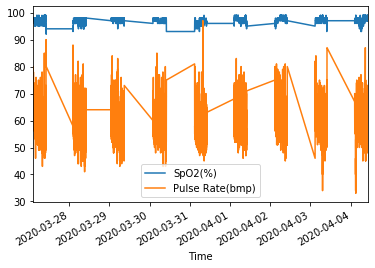

In [38]:
from ipywidgets import Output, IntSlider, VBox
from IPython.display import clear_output
out = Output()

slider = IntSlider()

def square(change):
    with out:
        clear_output()
        print(change.new*change.new)
        noches[['SpO2(%)', 'Pulse Rate(bmp)']].plot()
slider.observe(square, 'value')
slider.value = 50
display(VBox([slider, out]))

In [39]:
k = {}

In [40]:
k['desde'] = datetime.date(2020, 3, 27)
k['hasta'] = datetime.date(2020, 3, 30)
p={'dia': datetime.date(2020, 3, 28), 'SpO2(%)': 91}
k['menor'] = p


In [41]:
print(csv.shape[0])

68189


In [42]:

print(k['menor']['SpO2(%)'])

91


+ Estadísticas generales
    - Rango de fechas
    - Número de registros
    - media de registros por día
    - Número de noches y número de días
+ Estadísticas SpO2
    - Valor más bajo medido y si es día o noche
    - Valor más alto medido y si es día o noche
    - Valor medio
    - Valor medio día
    - Valor medio noche
    - Desviaciones típicas
    - Media SpO2 día
    - Media SpO2 noche
+ Estadísticas Pulsaciones
 (iguales a SpO2)



In [44]:
csv.groupby(pd.Grouper(freq='M')).mean()

,SpO2(%),Pulse Rate(bmp),Movimiento,Vibración
Time,,,,
2020-03-31,96.853772,59.617662,1.437215,0.003244
2020-04-30,97.376866,60.580680,0.698194,0.004454


In [45]:
print("Media por día\n", csv.groupby(pd.Grouper(freq='d')).mean())
print("\nDesviación Típica por día\n", csv.groupby(pd.Grouper(freq='d')).std())
print("\nNúmero de registros\n", csv.groupby(pd.Grouper(freq='d')).count())
print("\nNúmero de registros aggregate\n", csv.groupby(pd.Grouper(freq='d')).agg({'SpO2(%)':['count', 'mean']}))
print("\nNúmero de registros describe\n", csv.groupby(pd.Grouper(freq='d')).describe())

Media por día
               SpO2(%)  Pulse Rate(bmp)  Movimiento  Vibración
Time                                                         
2020-03-27  96.941384        62.019119    1.048931   0.016101
2020-03-28  96.398986        62.804631    2.841399   0.000000
2020-03-29  97.274345        55.935827    0.848256   0.000000
2020-03-30  96.884615        59.710069    1.076156   0.000000
2020-03-31  96.952131        55.663372    0.817326   0.000000
2020-04-01  97.581273        56.922312    0.767081   0.000000
2020-04-02  97.336966        62.349931    0.730069   0.000000
2020-04-03  97.275946        61.446961    0.720757   0.018349
2020-04-04  97.324257        61.379885    0.586243   0.000000

Desviación Típica por día
              SpO2(%)  Pulse Rate(bmp)  Movimiento  Vibración
Time                                                        
2020-03-27  1.367482        14.295777    5.275907   1.435577
2020-03-28  1.475132        14.396333    7.634547   0.000000
2020-03-29  0.556861         3.

In [46]:
print("\nNúmero de registros describe\n", csv['SpO2(%)'].groupby(pd.Grouper(freq='d')).describe())


Número de registros describe
               count       mean       std   min   25%   50%   75%   max
Time                                                                  
2020-03-27   7950.0  96.941384  1.367482  88.0  97.0  97.0  98.0  99.0
2020-03-28  10063.0  96.398986  1.475132  90.0  96.0  97.0  97.0  98.0
2020-03-29   7137.0  97.274345  0.556861  94.0  97.0  97.0  98.0  98.0
2020-03-30   7826.0  96.884615  0.915665  90.0  97.0  97.0  97.0  98.0
2020-03-31   6476.0  96.952131  0.520641  93.0  97.0  97.0  97.0  99.0
2020-04-01   6835.0  97.581273  0.716420  94.0  97.0  98.0  98.0  99.0
2020-04-02   7250.0  97.336966  1.377438  90.0  97.0  98.0  98.0  99.0
2020-04-03   6976.0  97.275946  1.008623  90.0  97.0  97.0  98.0  99.0
2020-04-04   7676.0  97.324257  1.164285  91.0  97.0  98.0  98.0  99.0


In [47]:
data = csv['SpO2(%)'].groupby(pd.Grouper(freq='d')).describe()

In [60]:
data.to_records()

rec.array([('2020-03-27T00:00:00.000000000',  7950., 96.94138365, 1.36748195, 88., 97., 97., 98., 99.),
           ('2020-03-28T00:00:00.000000000', 10063., 96.39898639, 1.47513242, 90., 96., 97., 97., 98.),
           ('2020-03-29T00:00:00.000000000',  7137., 97.27434496, 0.55686107, 94., 97., 97., 98., 98.),
           ('2020-03-30T00:00:00.000000000',  7826., 96.88461538, 0.91566472, 90., 97., 97., 97., 98.),
           ('2020-03-31T00:00:00.000000000',  6476., 96.95213095, 0.52064121, 93., 97., 97., 97., 99.),
           ('2020-04-01T00:00:00.000000000',  6835., 97.58127286, 0.71642004, 94., 97., 98., 98., 99.),
           ('2020-04-02T00:00:00.000000000',  7250., 97.33696552, 1.37743843, 90., 97., 98., 98., 99.),
           ('2020-04-03T00:00:00.000000000',  6976., 97.2759461 , 1.00862259, 90., 97., 97., 98., 99.),
           ('2020-04-04T00:00:00.000000000',  7676., 97.32425743, 1.1642852 , 91., 97., 98., 98., 99.)],
          dtype=[('Time', '<M8[ns]'), ('count', '<f8'), ('mean'

In [52]:
for d in data:
    print(d)

count
mean
std
min
25%
50%
75%
max


In [61]:
print(300*7/500)

4.2


In [62]:
dias

,SpO2(%),Pulse Rate(bmp),Movimiento,Vibración
Time,,,,
2020-03-27 21:14:11,95,91,0,0
2020-03-27 21:14:15,95,91,0,0
2020-03-27 21:14:19,96,87,2,0
2020-03-27 21:14:23,96,87,3,0
2020-03-27 21:14:27,96,88,0,0
...,...,...,...,...
2020-03-30 20:35:02,93,88,16,0
2020-03-30 20:35:06,93,90,27,0
2020-03-30 20:35:10,93,90,30,0


In [64]:
a=dias.index[0]

In [65]:
b=dias.index[1]

In [66]:
b-a

Timedelta('0 days 00:00:04')

In [67]:
b=dias.index[-1]

In [72]:
(b-a).days

2

In [73]:
(dias.index.max() - dias.index.min()).days

8

In [74]:
300*750/1250

180.0

In [75]:
300*30/1250


7.2

In [76]:
a=[1,2,3]
b=[4,5,6]
for k,m in zip(a,b):
    print(k,m)

1 4
2 5
3 6
